In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Dense, Conv2DTranspose, BatchNormalization, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

#Loading Cifar10 Data
def cifar10(X):
    with open(X, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

#Creating image array from Cifer10
def img(X):
    X = cifar10(X)
    X = X[b'data']
    X = X.reshape(X.shape[0],3,32,32)
    return X.transpose(0,2,3,1)

#Adding noise
def noise(X):
    noise = np.random.randint(-25,25,size=X.shape)
    X = X + noise
    X = np.clip(X, a_min = 0, a_max = 255)
    return X

#Creating noisey image array
def imgn(X):
    X = cifar10(X)
    X = X[b'data']
    X = noise(X)
    X = X.reshape(X.shape[0],3,32,32)
    return X.transpose(0,2,3,1)

#Loading Whole Traning data
def load_train(X):
    A = img(X + 'data_batch_1')
    for i in range(2,6):
        A = np.concatenate((A,img(X + 'data_batch_' + str(i))))
    B = imgn(X + 'data_batch_1')
    for i in range(2,6):
        B = np.concatenate((B,imgn(X + 'data_batch_' + str(i))))
    return A,B

#Loading test data
def load_test(X):
    return img(X + 'test_batch'),imgn(X + 'test_batch')

path = '/home/deb/cifar-10-batches-py/'
X_train, Y_train = load_train(path)
X_test, Y_test = load_test(path)
X_train, Y_train = X_train/255, Y_train/255
X_test, Y_test = X_test/255, Y_test/255

2023-05-27 12:04:56.249625: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-27 12:04:56.462528: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-27 12:04:56.463797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 12:04:57.795753: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [26]:
#Encoder
_input_ = Input(shape = (32, 32, 3))
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(_input_)
layer = BatchNormalization()(layer)
layer = MaxPool2D(pool_size = (2,2), padding = 'same')(layer)
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(layer)
layer = BatchNormalization()(layer)
layer = MaxPool2D(pool_size = (2,2), padding = 'same')(layer)

#Decoder
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(layer)
layer = BatchNormalization()(layer)
layer = UpSampling2D()(layer)
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(layer)
layer = BatchNormalization()(layer)
layer = UpSampling2D()(layer)
_output_ = Conv2D(3, (3,3), activation = 'sigmoid', padding = 'same')(layer)

autoencoder = Model(_input_,_output_,name = 'aencoder')
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

cp = ModelCheckpoint('aencoder.h5', save_best_only = True, save_weights_only = False, verbose = 1)
network = autoencoder.fit(Y_train, X_train, batch_size = 128, epochs =50, callbacks = cp, validation_split = 0.25, verbose = 2)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.60028, saving model to aencoder.h5
293/293 - 53s - loss: 0.5784 - val_loss: 0.6003 - 53s/epoch - 181ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.60028 to 0.56366, saving model to aencoder.h5
293/293 - 49s - loss: 0.5630 - val_loss: 0.5637 - 49s/epoch - 168ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.56366
293/293 - 47s - loss: 0.5602 - val_loss: 0.5646 - 47s/epoch - 162ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.56366 to 0.55970, saving model to aencoder.h5
293/293 - 47s - loss: 0.5588 - val_loss: 0.5597 - 47s/epoch - 161ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.55970 to 0.55876, saving model to aencoder.h5
293/293 - 47s - loss: 0.5578 - val_loss: 0.5588 - 47s/epoch - 161ms/step
Epoch 6/50

Epoch 6: val_loss improved from 0.55876 to 0.55815, saving model to aencoder.h5
293/293 - 47s - loss: 0.5571 - val_loss: 0.5582 - 47s/epoch - 161ms/step
Epoch 7/50

Epoch 7: val_loss improved from 0.5

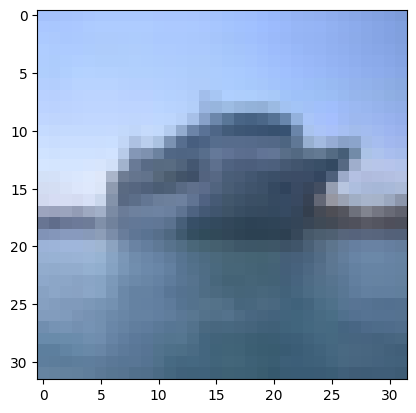

In [4]:
autoencoder = load_model('aencoder.h5')
plt.imshow(X_test[1004])

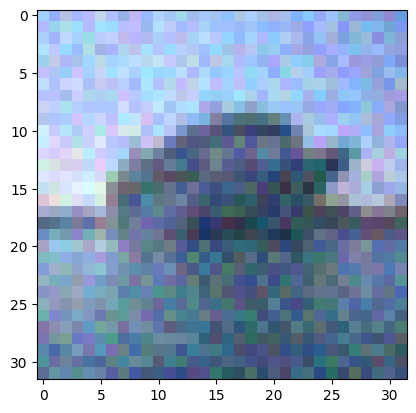

In [5]:
plt.imshow(Y_test[1004])

In [6]:
pred = autoencoder.predict(Y_test)
pred.shape

313/313 [==============================] - 5s 15ms/step


(10000, 32, 32, 3)

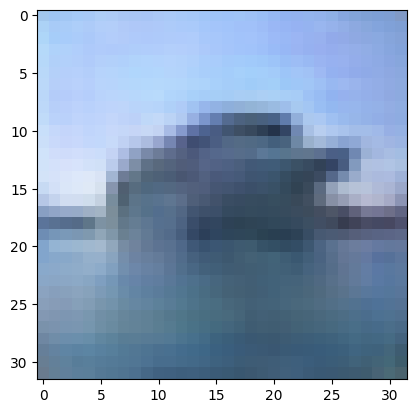

In [7]:
plt.imshow(pred[1004])